In [1]:
%matplotlib inline
import numpy as np
import glob
import astropy.table as astTable
import astropy.io.fits as pyfits
import xlens

In [7]:
cat_ref = astTable.Table.read(os.path.join(os.environ["CATSIM_DIR"], "OneDegSq.fits"))
tt = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_sim/tract_patch.csv")
tracts = np.unique(tt["tract"])

In [ ]:
isim = 0
irot = 1
out_dir = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode{isim}{irot}"
for tract in tracts:
    catalog = []
    patches = tt["patch"][tt["tract"] == tract]
    for patch in patches:
        fname = glob.glob(f"/work/xiangchong.li/work/hsc_s23b_sim/version1/anacal_catalog_db2_match/20250523T195240Z/sim_{isim}_rot{irot}_Coadd_anacal_match/{tract}/{patch}/*")[0]
        catalog.append(astTable.Table.read(fname))
    catalog = astTable.vstack(catalog)
    for band in ["g", "r", "i", "z", "y"]:
        catalog[f"{band}_mag_truth"] = cat_ref[catalog["index"]][f"{band}_ab"]
    catalog.write(os.path.join(out_dir, f"{tract}.fits"))

In [3]:
isim = 0
irot = 1
out_dir = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode{isim}{irot}"

In [4]:
out_dir

'/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode01'

In [ ]:
isim = 1
for irot in [0, 1]:
    out_dir = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode{isim}{irot}"
    for tract in tracts:
        catalog = []
        patches = tt["patch"][tt["tract"] == tract]
        for patch in patches:
            fname = glob.glob(f"/work/xiangchong.li/work/hsc_s23b_sim/version1/anacal_catalog_db2_match/20250523T195240Z/sim_{isim}_rot{irot}_Coadd_anacal_match/{tract}/{patch}/*")[0]
            catalog.append(astTable.Table.read(fname))
        catalog = astTable.vstack(catalog)
        for band in ["g", "r", "i", "z", "y"]:
            catalog[f"{band}_mag_truth"] = cat_ref[catalog["index"]][f"{band}_ab"]
        catalog.write(os.path.join(out_dir, f"{tract}.fits"))

In [59]:
mag={}
mag_dm = {}
mag_truth = {}
for band in ["g", "r", "i", "z", "y"]:
    mag.update(
        {band: 27 - np.log10(catalog[f"{band}_flux"]) * 2.5}
    )
    mag_dm.update(
        {band: 27 - 2.5 * np.log10(catalog[f"{band}_modelfit_CModel_instFlux"])}
    )
    mag_truth.update(
        {band: catalog[f"{band}_mag_truth"]}
    )

/tmp/ipykernel_4506/1608260607.py:6: RuntimeWarning: invalid value encountered in log10
  {band: 27 - np.log10(catalog[f"{band}_flux"]) * 2.5}
/tmp/ipykernel_4506/1608260607.py:9: RuntimeWarning: invalid value encountered in log10
  {band: 27 - 2.5 * np.log10(catalog[f"{band}_modelfit_CModel_instFlux"])}


In [8]:
in_dir = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode{isim}{irot}"
catalog = []
for tract in tracts[:20]:
    fname = os.path.join(in_dir, f"{tract}.fits")
    catalog.append(astTable.Table.read(fname))
catalog = astTable.vstack(catalog)

In [13]:
np.average(catalog["fpfs_de1_dg1"])

0.2652141496862601

In [15]:
np.min(catalog["dwsel_dg1"])

-1014.9166022166439

In [11]:
np.average(catalog["dwsel_dg1"] * catalog["fpfs_e1"])

-0.019044509309729556

In [12]:
np.average(catalog["dwsel_dg2"] * catalog["fpfs_e2"])

-0.02472369926749869

In [194]:
pwd

'/work/xiangchong.li/superonionGW/code/hsc_final/HSC_S23B_Shapes/notebook/2_shear_estimation'

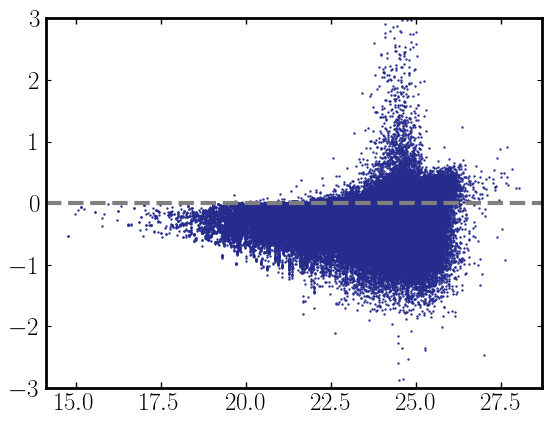

In [61]:
b1 = "g"
b2 = "r"
plt.scatter(mag_truth["i"], mag[b1] - mag[b2] - (mag_truth[b1] - mag_truth[b2]), s=0.5)
plt.ylim(-3, 3)
plt.axhline(y=0, color = "grey", ls ="--")

In [82]:
mag = 27 - np.log10(catalog["flux"]) * 2.5

0.8462566844919787
0.8520371643936054
0.8484094351974044
0.8386116253800184
0.795229935851486
0.6867939877290736
0.390362054056469


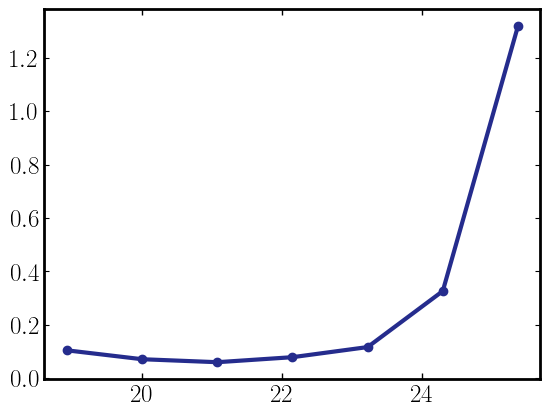

In [169]:
bins = np.histogram(mag, bins=12)[1][3: -2]
xs = []
ys = []
for i in range(len(bins) - 1):
    beg = bins[i]
    end = bins[i+1]
    msk = (mag>beg) & (mag<end)
    cc = catalog[msk]
    g_err = np.std(cc["fpfs_e1"] * cc["wsel"]) / np.average(cc["fpfs_de1_dg1"] * cc["wsel"] + cc["fpfs_e1"] * cc["dwsel_dg1"])
    xs.append((beg + end) / 2.0)
    ys.append(g_err**2.0)
xs = np.array(xs)
ys = np.array(ys)
plt.plot(xs, ys, "-o")

[0.15610947 0.15009007 0.1467889  0.19304585 0.3195229 ]


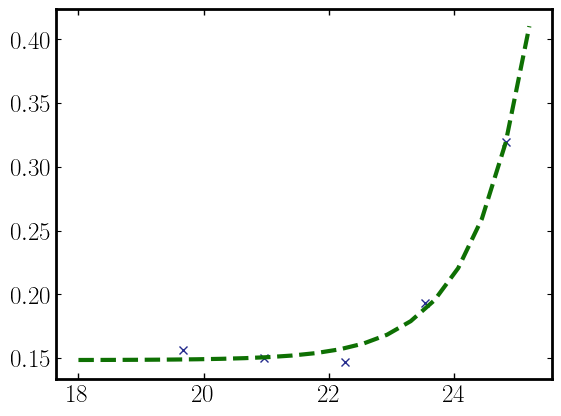

In [193]:
from scipy.optimize import curve_fit

bins = np.histogram(mag, bins=10)[1][3: -2]
xs = []
ys = []
ws = []
for i in range(len(bins) - 1):
    beg = bins[i]
    end = bins[i+1]
    msk = (mag>beg) & (mag<end)
    cc = catalog[msk]
    #g_err = np.std(cc["e1"] * cc["wsel"]) / np.average(cc["de1_dg1"] * cc["wsel"] + cc["e1"] * cc["dwsel_dg1"])
    xs.append((beg + end) / 2.0)
    g_err = np.std(cc["e1"]) ** 2.0
    ys.append(g_err)
    ws.append(np.average(cc["de1_dg1"] * cc["wsel"] + cc["e1"] * cc["dwsel_dg1"]))
xs = np.array(xs)
ys = np.array(ys)
ws = np.array(ws)

def exp_model(xs, a, b, c):
    return np.exp((xs - a) * b) + c

popt, pcov = curve_fit(exp_model, xs, ys, p0=(29.0, 0.3, 0.0))
plt.plot(xs, ys, "x" )
print(ys)
xx = np.linspace(18, 25.2, 20)
plt.plot(xx, exp_model(xx, popt[0], popt[1], popt[2]), "--")

In [191]:
ws

array([1.56564338, 1.4025304 , 1.17173534, 0.82490681, 0.65525574])

In [189]:
popt

array([26.38087395,  1.13467043,  0.14845216])

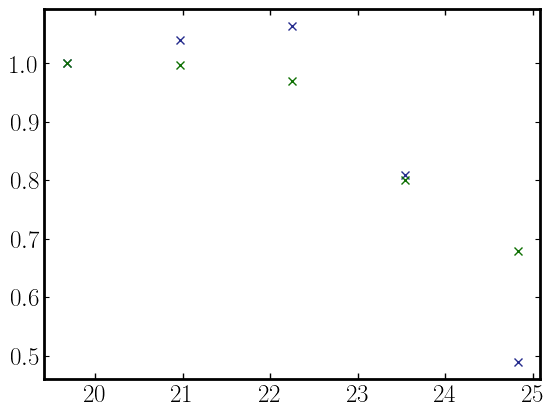

In [182]:
plt.plot(xs, ys[0] / ys, "x" )
plt.plot(xs, ws / ws[0], "x" )

In [168]:
popt

array([26.61595004,  0.60809524,  0.03284759])

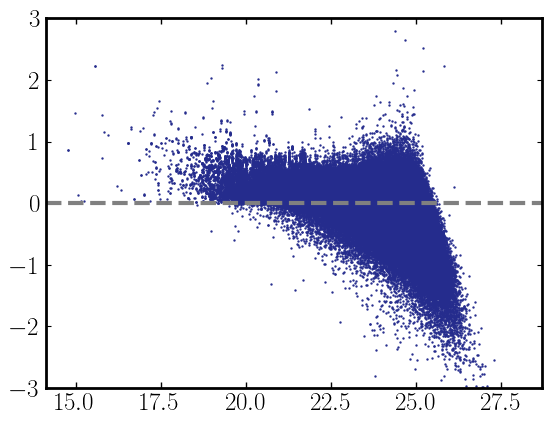

In [69]:
b1 = "z"
mag2 = 27 - np.log10(catalog["flux"]) * 2.5
plt.scatter(mag_truth["i"], mag[b1] - (mag_truth[b1]), s=0.5)
plt.ylim(-3, 3)
plt.axhline(y=0, color = "grey", ls ="--")

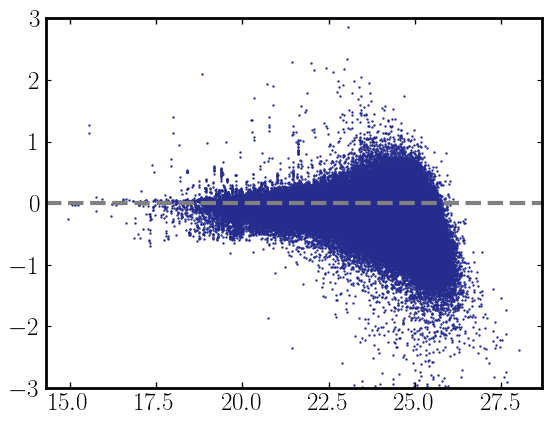

In [70]:
b1 = "z"
plt.scatter(mag_truth["i"], mag_dm[b1]- (mag_truth[b1]), s=0.5)
plt.ylim(-3, 3)
plt.axhline(y=0, color = "grey", ls ="--")

In [48]:
len(data)

3471